In [ ]:
from cobalt_tractography.bossHandler import *
from cobalt_tractography.tractography import *
import numpy as np
from skimage import img_as_uint


In [ ]:
# Parameters:
coll_name = 'ailey-dev'
exp_name = '170726_Insula-vCapture-Atenolol2_00-56-01'
chan_name = 'Ch0'
x_rng = [9250, 9750]
y_rng = [18000, 18500]
z_rng = [500, 600]
test_lbl = '4'

# Using bossHandler class to download from Boss:
bHandler = bossHandler(coll_name)
bHandler.select_experiment(exp_name)
exp = bHandler.get_experiment()
bHandler.select_channel(chan_name)
# data_cutout_raw = bHandler.get_cutout(x_rng, y_rng, z_rng)
bHandler.get_coordinate_frame()
data_cutout_raw = bHandler.get_all()
data_cutout_raw = np.transpose(img_as_uint(data_cutout_raw),(1,2,0))

In [4]:
data_cutout_raw.shape

(1454, 2560, 2160)

In [5]:
th = tractoHandler(data_cutout_raw)
skeleton, concomp, concomp_col, data_cutout_binarized =th.run_tractography(1)

slice-by-slice with subsampling


MemoryError: 

## Visualize (animated)
Visualize as an animation iterating through z slices

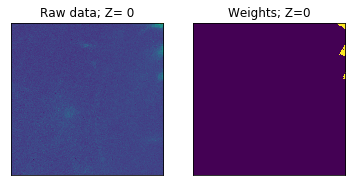

In [4]:
# Visualize the output (animation)

from matplotlib import animation
from IPython.display import HTML

z_rng = [0 , data_cutout_raw.shape[2]]
# z_rng = [70,80]
fig, (im1, im2) = plt.subplots(1, 2)

# fig.set_facecolor('black')
ax1 = im1.imshow(data_cutout_raw[:,:,0], animated=True)
ax2 = im2.imshow(data_cutout_binarized[:,:,0], animated=True)

im1.get_xaxis().set_visible(False)
im2.get_xaxis().set_visible(False)

im1.get_yaxis().set_visible(False)
im2.get_yaxis().set_visible(False)

im1.set_title('Raw data')
im2.set_title('Weights')

def animate(i):
    ax1.set_data(data_cutout_raw[:,:,i])
    im1.set_title('Raw data; Z= ' + str(i))
#     ax1.set_cmap('gray')
    ax1.autoscale()
    
    ax2.set_data(data_cutout_binarized[:,:,i])
    im2.set_title('Weights; Z=' + str(i))
#     ax2.set_cmap('gray')
    ax2.autoscale()
    return ax1

anim = animation.FuncAnimation(fig, animate, frames = np.arange(z_rng[0],z_rng[1]), interval = 50)
HTML(anim.to_jshtml())


## Quantitative plot
For each machine labeled voxel find the closest manually labeled and calculate the physical distance


(2216, 3)


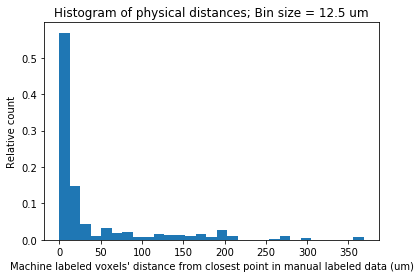

In [5]:
labeled_0_nz_voxel_ids = np.genfromtxt('../../../annotation_csv/tractography/tractography_'+test_lbl+'.swc' , delimiter=' ')
labeled_0_nz_voxel_ids = np.around(np.uint16(labeled_0_nz_voxel_ids[:,2:5]))
labeled_0_nz_voxel_ids = labeled_0_nz_voxel_ids[:, [1,0,2]]
nz_skeleton = np.asarray(np.nonzero(skeleton)).T

# physical sizes:
x_size = 0.585 #um
y_size = 0.585 #um
z_size = 5.0 #um
method = 'm2l' #m2l (for each machine labled find the closest manual labels) or 
               #l2m (for each manual labeled find the closest machine labeled)

nz_test_data = np.asarray(np.nonzero(skeleton)).T
if method == 'm2l':
    closest_voxels = th.quantify(nz_skeleton, labeled_0_nz_voxel_ids)
    subtrct = closest_voxels - nz_skeleton
elif method == 'l2m':
    closest_voxels = th.quantify(labeled_0_nz_voxel_ids, nz_skeleton)
    subtrct = closest_voxels - labeled_0_nz_voxel_ids
    
distances = np.linalg.norm(subtrct.dot(np.diag([x_size, y_size, z_size])), axis = 1)
binSize = 12.5 #um
nbins = np.uint32(np.around((np.max(distances) - np.min(distances))/12.5))

histret=plt.hist(distances, bins=nbins, weights=np.zeros_like(distances) + 1. / distances.size )
plt.xlabel((
    'Machine labeled' if method == 'm2l' else 'Manual labled' ) + ' voxels\' distance from closest point in ' + (
    'manual labeled data (um)' if method == 'm2l' else 'machine labeled data (um)'))
plt.ylabel('Relative count')
plt.title('Histogram of physical distances; Bin size = ' + str(binSize) + ' um')
print(closest_voxels.shape)


## Save overlaid tiff volume for visualization
The saved tiff stack contains overlain raw, results and the labeled 

In [6]:
overlaidFileName = '../output_data/test_tractography/test_'+test_lbl+'_overlaid_80th_sub-to-10k.tiff'

cmap = plt.cm.get_cmap('nipy_spectral' , np.unique(concomp).size)
overlaid = color.gray2rgb(img_as_ubyte(data_cutout_raw))
overlaid[skeleton != 0] = np.asarray([255,0,0], dtype='uint8')

for row in labeled_0_nz_voxel_ids:
    if np.array_equal(overlaid[row[0] , row[1] , row[2],:] , np.asarray([255,0,0], dtype='uint8')):
        overlaid[row[0] , row[1] , row[2],:] = np.asarray([255,255,0], dtype='uint8')
    else:
        overlaid[row[0] , row[1] , row[2],:] = np.asarray([0,255,0], dtype='uint8')
                                                          
imsave(overlaidFileName , overlaid)

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


## Save results as swc

In [ ]:
swcFileName = '../output_data/test_tractography/CSV_outputs/test_4_output_nosubs.swc'

unique_vals = np.unique(concomp)

clust_ids = np.empty((unique_vals.shape[0]-1))
outputmat = np.empty(((0,3)))
for i,cluster in enumerate(unique_vals[1:]):
        curr_clust = np.asarray(np.where( concomp == cluster )).T
        clust_ids[i] = curr_clust.shape[0]
        outputmat = np.append(outputmat , curr_clust, axis=0)


clust_ids = np.append([0] , np.cumsum(clust_ids)[:-1])

first_col = np.arange(1, outputmat.shape[0]+1).reshape(outputmat.shape[0],1)
second_col = 3*np.ones((outputmat.shape[0],1))
outputmat = np.append(second_col,outputmat, axis=1)
outputmat = np.append(first_col,outputmat, axis=1)

second_to_last_col = np.ones((outputmat.shape[0],1))
outputmat = np.append(outputmat, second_to_last_col, axis=1)
last_col = np.arange(outputmat.shape[0]).reshape(outputmat.shape[0],1)
last_col[np.uint16(clust_ids)] = -1
outputmat = np.append(outputmat, last_col ,axis=1)

np.savetxt(swcFileName , outputmat, fmt='%i')

## Ingest to Boss
Upload the results back to Boss


In [ ]:

# Helper functions for ingestation (C: vikram)
def get_channel_resource(rmt, chan_name, coll_name, exp_name, type='image', base_resolution=0, sources=[], datatype='uint16', new_channel=True):
    channel_resource = ChannelResource(chan_name, coll_name, exp_name, type=type, 
                                    base_resolution=base_resolution, sources=sources, datatype=datatype)
    if new_channel: 

        new_rsc = rmt.create_project(channel_resource)
        return new_rsc

    return channel_resource



def upload_to_boss(rmt, data, channel_resource, resolution=0):
    Z_LOC = 0
    size = data.shape
    for i in range(0, data.shape[Z_LOC], 16):
        last_z = i+16
        if last_z > data.shape[Z_LOC]:
            last_z = data.shape[Z_LOC]
        print(resolution, [0, size[2]], [0, size[1]], [i, last_z])
        rmt.create_cutout(channel_resource, resolution, [0, size[2]], [0, size[1]], [i, last_z], np.asarray(data[i:last_z,:,:], order='C'))
        
        
# Ingest the results back to Boss
rmt = BossRemote()
new_coll_name = 'tractography'
new_exp_name = 'mvpsprint3'
new_chan_name = 'annot_4'
create_new_channel = False

if create_new_channel:
    # new channel
    new_chan_resource = get_channel_resource(rmt, new_chan_name, new_coll_name, new_exp_name , new_channel=True)
    upload_to_boss(rmt, concomp, new_chan_resource)
    
else:
    # get existing channel
    chan_resource = rmt.get_channel(chan_name= new_chan_name, coll_name=new_coll_name, exp_name=new_exp_name)
    upload_to_boss(rmt, concomp, chan_resource)
